# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('display.max_columns', None)
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

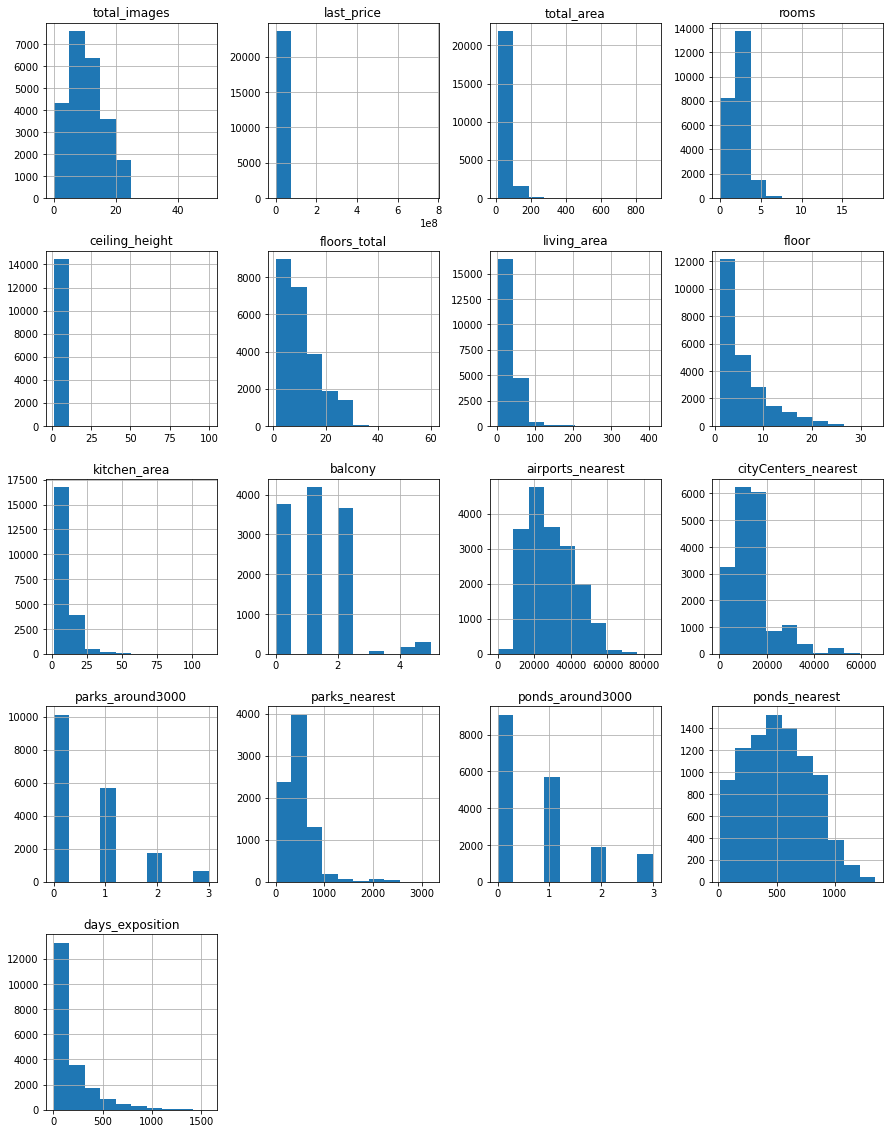

In [3]:
data.hist(figsize=(15, 20));


Данные имеют пропуски, нверный тип данных, дубликаты явные и неявные, разный регистр названия колонок, нетипичные значения.

### Предобработка данных

In [4]:
data.rename(columns={'cityCenters_nearest' : 'city_centers_nearest'}, inplace=True)#запись в нижнем регистре

In [5]:
data.isna().sum()#поиск пропусков и их количество

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
city_centers_nearest     5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Количество обнаруженных Null из 23699:
9195 ceiling_height - около 1/3 объявлений пропущена высота потолков, остается Null.
86 floors_total - данные не заполнены, из выборки, остается Null.
1903 living_area - остается Null.
20924 is_apartment - возможно, это не апартаменты и присвоить False.
2278 kitchen_area - проверить это - студия ли, если нет, то останется Null.
11519 balcony - предположительно нет балконов, заполняем 0
49 locality_name - данные были не заполнены, остается Null
5542 airports_nearest - аэропортов рядом нет, остается Null
5519 city_centers_nearest - центр города не близко, остается Null
5518 parks_around3000 - парки отсутствуют в радиусе 3км, остается Null
15620 parks_nearest - парки отсутствуют, остается Null
5518 ponds_around3000 - пруды отсутствуют в радиусе 3км, остается Null
14589 ponds_nearest - пруды отсутствуют, остается Null
3181 days_exposition - объявление не было опубликовано, остается Null

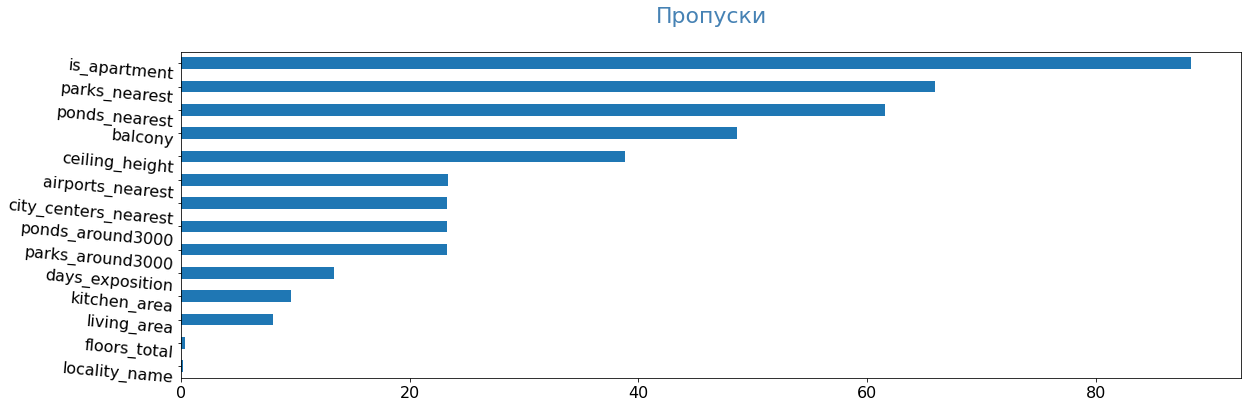

In [6]:
def pass_value_barh(data):#написание функции с бритвой Оккама
    (
        (data.isna().mean()*100)
        .to_frame()
        .rename(columns = {0:'space'})
        .query('space > 0')
        .sort_values(by = 'space', ascending = True)
        .plot(kind= 'barh', figsize=(19,6), rot = -5, legend = False, fontsize = 16)
        .set_title('Пропуски' + "\n", fontsize = 22, color = 'SteelBlue')    
    );    
pass_value_barh(data)

In [7]:
data['balcony'] = data['balcony'].fillna(0)#замена Null 'балконы' на '0'

In [8]:
data['is_apartment'] = data['is_apartment'].fillna('False')#замена Null 'апартаменты' на 'False'

In [9]:
data['locality_name'].dropna(inplace=True)#удаление строки с Null 'locality_name'

In [10]:
data['floors_total'].dropna(inplace=True)#удаление строки с Null 'floors_total'

In [11]:
data['ceiling_height'] = data['ceiling_height'].fillna(2.70)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        23699 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          23699 non-null  object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               23699 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Необходимо сменить тип данных для:
last_price - int64
first_day_exposition - date
floors_total - Int8 nullable-integer extension dtype
is_apartment - bool
balcony - int8
days_exposition - int64
Изменение типа для first_day_exposition требуется, чтобы работать с датой было удобно.
Изменение типа для is_apartment требуется, чтобы работать с булевым значением и сэкономить память.
Изменение типов других колонок требуется для экономии памяти.

In [13]:
#изменение типов данных с помощью конструкции try-except для работы с непредсказуемым поведением, т.е. на случай ошибки
try:
    data['last_price'] = data['last_price'].astype('int64')
    print('1ok')
except:
    print('last_price int type conversion fail')
    
try:    
    data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'],format='%Y-%m-%dT%H:%M:%S')
    print('2ok')
except:
    print('first_day_exposition to_datetime type conversion fail')
    
try:
    data['floors_total'] =  data['floors_total'].astype('Int8')
    print('3ok')
except:
    print('floors_total int8 type conversion fail')
      
try:
    data['is_apartment'] = data['is_apartment'].map({'False':False, 'True':True})
    print('4ok')
except:
    print('is_apartment bool type conversion fail')
        
try:
    data['balcony'] = data['balcony'].astype('int8')
    print('5ok')
except:
    print('balcony int8 type conversion fail')
    
try:
    data['days_exposition'] = np.floor(pd.to_numeric(data['days_exposition'], errors='coerce')).astype('Int64')
    print('6ok')
except:
    print('days_exposition int64 type conversion fail')

1ok
2ok
3ok
4ok
5ok
6ok


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  int64         
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  Int8          
 7   living_area           21796 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          20924 non-null  object        
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

In [15]:
def loc_length():
    return print('Количество уникальных занчений locality_name:', data['locality_name'].unique().shape[0])
loc_length()

Количество уникальных занчений locality_name: 365


In [16]:
#нижний регистр для всех названий
data['locality_name'] = data['locality_name'].str.lower()

In [17]:
#замена 'ё' на 'е'
data['locality_name'] = data['locality_name'].str.replace('ё', 'е')

In [18]:
#замена 'городской поселок' на 'поселок городского типа'
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')

In [19]:
#проверка дубликатов
print('Количетво явных дубликатов:', data.duplicated().sum())

Количетво явных дубликатов: 0


In [20]:
locality_township = []
for x in data['locality_name'].unique():
    try:
        if 'городского типа' in x:
            locality_township.append(x)
    except:
        print('Ошибка в цикле из-за значения:', x)      

Ошибка в цикле из-за значения: nan


In [21]:
unique_locality = pd.Series(data['locality_name'].unique())#уникальные значения населенных пунктов
unique_locality

0                      санкт-петербург
1                       поселок шушары
2      поселок городского типа янино-1
3                    поселок парголово
4                       поселок мурино
                    ...               
319                     деревня нижняя
320          коттеджный поселок лесное
321                  деревня тихковицы
322             деревня борисова грива
323               поселок дзержинского
Length: 324, dtype: object

In [22]:
#преобразование DataFrame для подсчета количество входжений названия посёлков городского типа в 'unique_locality'
locality_df = pd.DataFrame(locality_township)
locality_df = locality_df.rename(columns={0:'name'})
locality_df['name'] = locality_df['name'].str.replace('поселок городского типа ', '')
locality_df

,name
0,янино-1
1,красный бор
2,лебяжье
3,сиверский
4,кузьмоловский
5,ефимовский
6,рощино
7,синявино
8,советский
9,токсово


In [23]:
#устранение неявных дубликатов
for index, row in locality_df.iterrows():
     if unique_locality.str.contains(row['name']).sum() > 1:
        print(row['name'])
        data['locality_name'] = data['locality_name'].str.replace('поселок '+row['name'], 'поселок городского типа '+row['name'])
loc_length()

павлово
рахья
федоровское
приладожский
рябово
Количество уникальных занчений locality_name: 323


In [24]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,21796.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.743758,10.673824,34.457852,5.892358,10.569807,0.591080,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,0.987138,6.597173,22.030445,4.885249,5.905438,0.959298,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.300000,8.000000,12.000000,1.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


In [25]:
print('Квартир стоимостью 0:', data.query('last_price == 0')['last_price'].count())
print('Квартир стоимостью меньше 100.000:', data.query('last_price < 1e+05')['last_price'].count())
print('Квартир стоимостью меньше 1.000.000:', data.query('last_price < 1e+07')['last_price'].count())
print('Квартир стоимостью больше 100.000.000:', data.query('last_price > 1e+08')['last_price'].count())
data.drop(index=data.query('last_price > 1e+08').index,inplace=True)

Квартир стоимостью 0: 0
Квартир стоимостью меньше 100.000: 1
Квартир стоимостью меньше 1.000.000: 20917
Квартир стоимостью больше 100.000.000: 37


Отсутствуют квартир стоимостью 0.
Одна квартира стоимостью меньше 100 000, можно не учитывать.
Удаляем слишком дорогие квартиры более 100.000.000.
20917 квартир стоимостью меньше 1млн - не похоже на выброс, оставляем.

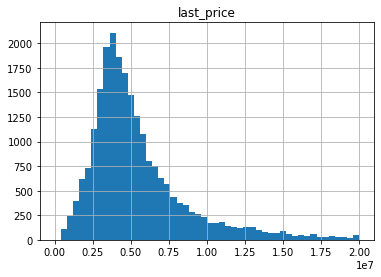

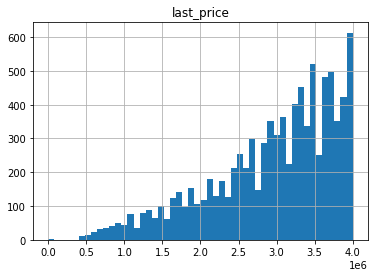

In [26]:
import matplotlib.pyplot as plt
data.hist('last_price', bins=50, range=(0,2e+07))
data.hist('last_price', bins=50, range=(0,4e+06))

data.drop(index=data.query('last_price < 1e+05').index,inplace=True)

In [27]:
print('Квартир площадью менее 10 кв.м.:',data.query('total_area < 10')['total_area'].count()) 
print('Квартир площадью более 500 кв.м.:',data.query('total_area > 500')['total_area'].count())

Квартир площадью менее 10 кв.м.: 0
Квартир площадью более 500 кв.м.: 3


Квартир площадью > 500 кв.м. мало, можно удалить.

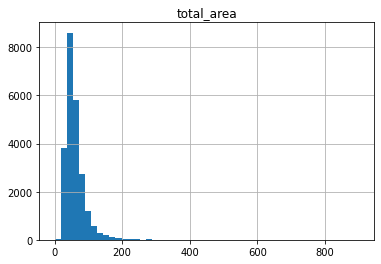

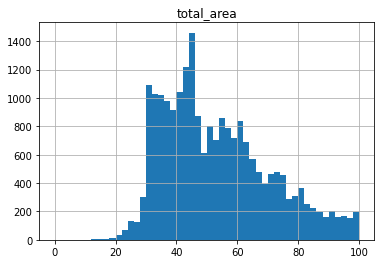

In [28]:
data.hist('total_area', bins=50, range=(0,900))
data.hist('total_area', bins=50, range=(0,100))
data.drop(index=data.query('total_area > 500').index,inplace=True)

In [29]:
print('Квартиры без комнат:',data.query('rooms == 0')['rooms'].count())
print('Квартиры без комнат и студии:',data.query('rooms == 0 and studio')['rooms'].count()) 
print('Квартиры без комнат и апартаменты:',data.query('rooms == 0 and is_apartment')['rooms'].count()) 
print('Квартиры без комнат и свободная планировка:',data.query('rooms == 0 and open_plan')['rooms'].count())
print('Квартиры без комнат не апартаменты и не свободная планировка:',data.query('rooms == 0 and ~open_plan and ~studio')['rooms'].count())
data.drop(index=data.query('rooms > 7').index,inplace=True)

Квартиры без комнат: 197
Квартиры без комнат и студии: 138
Квартиры без комнат и апартаменты: 0
Квартиры без комнат и свободная планировка: 59
Квартиры без комнат не апартаменты и не свободная планировка: 0


Проверка: студии, апартаменты, свободная планировка

In [30]:
print('Квартиры с потолками от 4м до 5м: ' + str(data.query('ceiling_height > 4 and ceiling_height <= 5')['ceiling_height'].count()) + ' шт.')
print('Квартиры с потолками от 5м до 25м: ' + str(data.query('ceiling_height > 5 and ceiling_height < 25')['ceiling_height'].count()) + ' шт.')
print('Квартиры с потолками от 25м до 36м: ' + str(data.query('ceiling_height >= 25 and ceiling_height <= 36')['ceiling_height'].count()) + ' шт.')
print('Квартиры с потолками от 25м до 36м: ' + str(data.query('ceiling_height > 36 and ceiling_height < 50')['ceiling_height'].count()) + ' шт.')
print('Квартиры с потолками от 50м: ' + str(data.query('ceiling_height >= 50')['ceiling_height'].count()) + ' шт.')

data.drop(index=data.query('ceiling_height > 4 and ceiling_height < 25').index,inplace=True)
data.update(data[(data['ceiling_height'] >= 25) & (data['ceiling_height'] <= 36)]['ceiling_height']/10)
data.drop(index=data.query('ceiling_height > 36').index,inplace=True)

Квартиры с потолками от 4м до 5м: 36 шт.
Квартиры с потолками от 5м до 25м: 14 шт.
Квартиры с потолками от 25м до 36м: 19 шт.
Квартиры с потолками от 25м до 36м: 0 шт.
Квартиры с потолками от 50м: 1 шт.


Необходимо удалить квартиры с высотой потолков от 4 до 25 метров.
Для квартир с высотой потолков до 25 до 36 метров предполагается, что это является опечаткой, разделить на 10, итог: 2.5 и 3.6 метра.
Удаляем квартиры с высотой потолков от 36 метров.

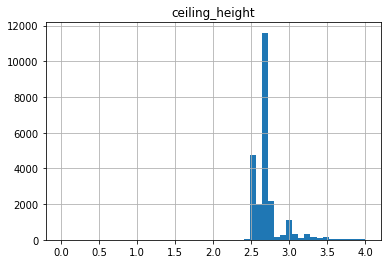

In [31]:
data.hist('ceiling_height',bins=50,range=(0,4));

В жилых домах по СНиПу высота потолков устанавливается с учетом минимальных требований равной 2,5 - 3,2 метров, независимо от года постройки и от типа здания, следовательно удаляем значения менее 2,5.

In [32]:
print('Квартиры с потолками меньше 2.5м : ' + str(data.query('ceiling_height < 2.5')['ceiling_height'].count()) + ' шт.')
data.drop(index=data.query('ceiling_height < 2.5').index,inplace=True)

Квартиры с потолками меньше 2.5м : 73 шт.


Квартиры в одноэтажных домах :  23
Квартиры в >30 этажных домах :  31


array([[<AxesSubplot:title={'center':'floors_total'}>]], dtype=object)

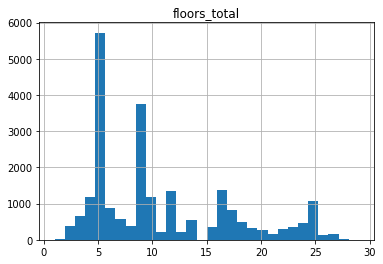

In [33]:
print('Квартиры в одноэтажных домах : ',data.query('floors_total == 1')['floors_total'].count())
print('Квартиры в >30 этажных домах : ',data.query('floors_total > 30')['floors_total'].count())

data.drop(index=data.query('floors_total > 30').index,inplace=True)

data.hist('floors_total', bins=30)

Жилая площадь меньше 10 кв.м.:  25
Жилая площадь больше общей:  0
Жилая площадь больше 200:  12


array([[<AxesSubplot:title={'center':'living_area'}>]], dtype=object)

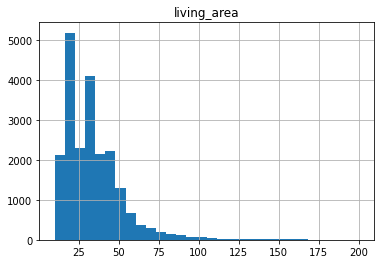

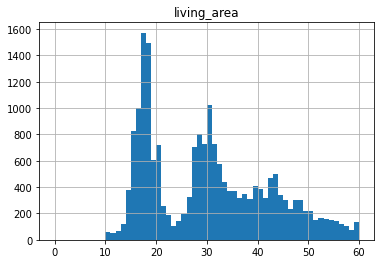

In [34]:
print('Жилая площадь меньше 10 кв.м.: ',data.query('living_area < 10')['living_area'].count())
print('Жилая площадь больше общей: ',data.query('living_area > total_area')['living_area'].count())
print('Жилая площадь больше 200: ',data.query('living_area > 200')['living_area'].count())

data.drop(index=data.query('living_area < 10').index,inplace=True)
data.drop(index=data.query('living_area > 200').index,inplace=True)

data.hist('living_area', bins=30);
data.hist('living_area', bins=60, range=(0,60))

Удалим значения с жилой площадью меньше 10кв.м. и квартиры с площадью более 200 кв.м.

Этаж 0 0
Этаж 0 0
Этаж превышающий количества этажей:  0


array([[<AxesSubplot:title={'center':'floor'}>]], dtype=object)

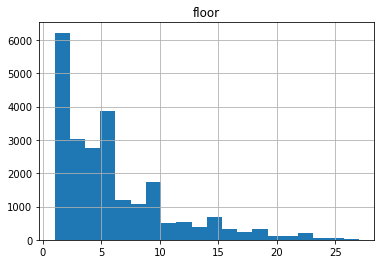

In [35]:
print('Этаж 0',data.query('floor == 0')['floor'].count())
print('Этаж 0',data.query('floor > 30')['floor'].count())
print('Этаж превышающий количества этажей: ',data.query('floor > floors_total')['floor'].count())

data.hist('floor',bins=20)

Площадь кухни < 2 кв.м.:  1
Площадь кухни 5 кв.м.:  351
Площадь кухни > 50 кв.м.:  33
Площадь кухни больше общей:  0


array([[<AxesSubplot:title={'center':'kitchen_area'}>]], dtype=object)

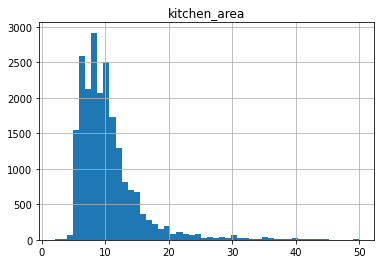

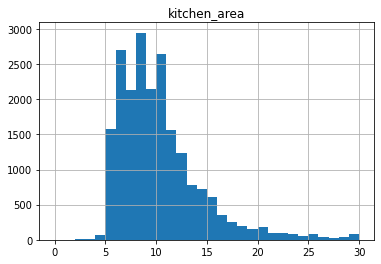

In [36]:
print('Площадь кухни < 2 кв.м.: ',data.query('kitchen_area < 2')['living_area'].count())
print('Площадь кухни 5 кв.м.: ',data.query('kitchen_area == 5')['living_area'].count())
print('Площадь кухни > 50 кв.м.: ',data.query('kitchen_area > 50')['living_area'].count())
print('Площадь кухни больше общей: ',data.query('kitchen_area > total_area')['living_area'].count())

data.drop(index=data.query('kitchen_area < 2').index,inplace=True)
data.drop(index=data.query('kitchen_area > 50').index,inplace=True)

data.hist('kitchen_area', bins=50);
data.hist('kitchen_area', bins=30, range=(0,30))

Следует удалить строки с кухнями менее 2кв.м. и более 50кв.м.

array([[<AxesSubplot:title={'center':'balcony'}>]], dtype=object)

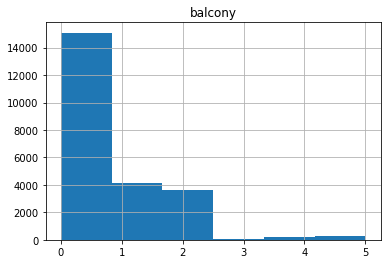

In [37]:
data.hist('balcony', bins=6)

Объявление не было оопубликовано:  0
Объявлению больше 3 лет :  165


array([[<AxesSubplot:title={'center':'days_exposition'}>]], dtype=object)

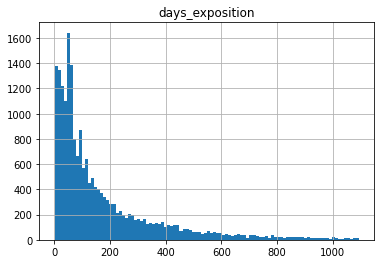

In [38]:
print('Объявление не было оопубликовано: ',data.query('days_exposition == 0')['days_exposition'].count())
print('Объявлению больше 3 лет : ',data.query('days_exposition > 365*3')['days_exposition'].count())

data.drop(index=data.query('days_exposition > 365*3').index,inplace=True)
data.hist('days_exposition', bins=100)

Удалить объявление, которое было опубликовано больше 3 лет

Квартиры очень близко к аэропорту: 1


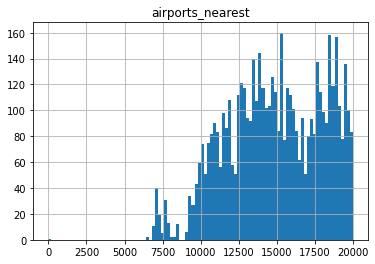

In [39]:
print('Квартиры очень близко к аэропорту:',data.query('airports_nearest < 5000')['airports_nearest'].count())
data.hist('airports_nearest', bins=100, range=(0,20000));

data.drop(index=data.query('airports_nearest < 5000').index,inplace=True)

In [40]:
#обновление индексации
data.reset_index(drop=True,inplace=True)

In [41]:
(
    data[['rooms', 'total_area', 'ceiling_height', 'days_exposition', 'last_price', 'living_area',  'kitchen_area', 'floor',
       'floors_total']]
    .apply (['count', 'min', 'max'])   
    .style.format("{:,.2f}")
)

,rooms,total_area,ceiling_height,days_exposition,last_price,living_area,kitchen_area,floor,floors_total
count,"23,238.00","23,238.00","23,238.00","20,105.00","23,238.00","21,368.00","21,001.00","23,238.00","23,154.00"
min,0.00,12.00,2.50,1.00,"430,000.00",10.00,2.00,1.00,1.00
max,7.00,494.10,4.00,"1,095.00","99,000,000.00",200.00,50.00,27.00,29.00


In [42]:
data.rooms.value_counts().to_frame()

,rooms
1,7957
2,7814
3,5702
4,1138
5,297
0,192
6,94
7,44


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23238 entries, 0 to 23237
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23238 non-null  int64         
 1   last_price            23238 non-null  int64         
 2   total_area            23238 non-null  float64       
 3   first_day_exposition  23238 non-null  datetime64[ns]
 4   rooms                 23238 non-null  int64         
 5   ceiling_height        23238 non-null  float64       
 6   floors_total          23154 non-null  Int8          
 7   living_area           21368 non-null  float64       
 8   floor                 23238 non-null  int64         
 9   is_apartment          20522 non-null  object        
 10  studio                23238 non-null  bool          
 11  open_plan             23238 non-null  bool          
 12  kitchen_area          21001 non-null  float64       
 13  balcony         

Устранились редкие и выбивающиеся значения: rooms > 7, total_area > 500, days_exposition > 365*3, last_price > 100.000.000, living_area > 200, floors_total > 30, а также значения Null для locality_name, floors_total.

### Посчитайте и добавьте в таблицу новые столбцы

In [44]:
#цена одного квадратного метра
data['cost_per_sqm'] = data['last_price'] / data['total_area']


In [45]:
#день публикации объявления (0 - понедельник, 1 - вторник и т.д.)
data['dayofweek'] = data['first_day_exposition'].dt.dayofweek


In [46]:
#месяц публикации объявления
data['month'] = data['first_day_exposition'].dt.month


In [47]:
#год публикации объявления
data['year'] = data['first_day_exposition'].dt.year


In [48]:
#тип этажа квартиры (значения — «первый», «последний», «другой»)
data['floor_category'] = data.apply(
    lambda x: 'первый' if (x.floor == 1) 
    else ('последний' if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 'другой'), axis=1
)

data['floor_category_digit'] = data.apply(
    lambda x: 0 if (x.floor == 1) 
    else (2 if (x.floor == x.floors_total) & isinstance(x.floors_total,int) 
    else 1), axis=1
)
data['floor_category_digit'].value_counts()


1    17126
2     3242
0     2870
Name: floor_category_digit, dtype: int64

In [49]:
#расстояние в км до центра города
data['city_centers_nearest_km'] = round(data['city_centers_nearest'] / 1000)
try:
    data['city_centers_nearest_km'] =  data['city_centers_nearest_km'].astype('Int32')
    print('city_centers_nearest_km ok')
except:
    print('city_centers_nearest_km Int32 type conversion fail')

city_centers_nearest_km ok


### Проведите исследовательский анализ данных

In [50]:
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sqm,dayofweek,month,year,floor_category_digit,city_centers_nearest_km
count,23238.000000,2.323800e+04,23238.000000,23238.000000,23238.000000,23154.00000,21368.000000,23238.000000,21001.000000,23238.000000,17759.000000,17779.000000,17780.000000,7849.000000,17780.000000,8847.000000,20105.00000,23238.000000,23238.000000,23238.000000,23238.000000,23238.000000,17779.000000
mean,9.858077,6.108102e+06,59.074842,2.048369,2.711290,10.67673,33.755706,5.888200,10.369042,0.591660,28837.335548,14255.889476,0.604274,490.441203,0.758774,521.744885,171.42855,98173.002968,2.572295,6.399604,2017.386608,1.016008,14.250183
std,5.674362,5.928683e+06,30.372824,1.020545,0.197001,6.53913,19.147684,4.864067,5.113107,0.958633,12671.917542,8577.369000,0.796092,340.188883,0.929011,277.184448,197.24259,42202.335644,1.789668,3.487239,1.020104,0.512613,8.585534
min,0.000000,4.300000e+05,12.000000,0.000000,2.500000,1.00000,10.000000,1.000000,2.000000,0.000000,6450.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.00000,7962.962963,0.000000,1.000000,2014.000000,0.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.00000,18.600000,2.000000,7.000000,0.000000,18500.000000,9403.000000,0.000000,288.000000,0.000000,299.000000,44.00000,76473.945743,1.000000,3.000000,2017.000000,1.000000,9.000000
50%,9.000000,4.600000e+06,52.000000,2.000000,2.700000,9.00000,30.000000,4.000000,9.000000,0.000000,26835.000000,13145.000000,0.000000,455.000000,0.000000,506.000000,93.00000,94789.198262,3.000000,6.000000,2017.000000,1.000000,13.000000
75%,14.000000,6.700000e+06,69.000000,3.000000,2.700000,16.00000,42.000000,8.000000,12.000000,1.000000,37364.000000,16296.000000,1.000000,612.000000,1.000000,733.000000,224.00000,113761.467890,4.000000,10.000000,2018.000000,1.000000,16.000000
max,50.000000,9.900000e+07,494.100000,7.000000,4.000000,29.00000,200.000000,27.000000,50.000000,5.000000,84853.000000,65952.000000,3.000000,3190.000000,3.000000,1344.000000,1095.00000,848484.848485,6.000000,12.000000,2019.000000,2.000000,66.000000


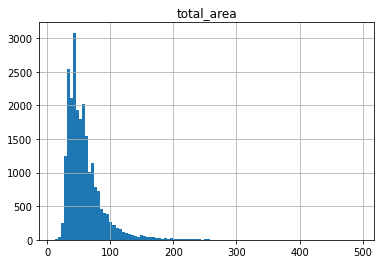

In [51]:
data.hist('total_area', bins=100);

Наблюдается незначительное количество квартир с общей площадью более 100 кв.м. Если построить диаграмму размаха, то будет немного значений, которые покажутся выбросами, это элитная недвижимость.

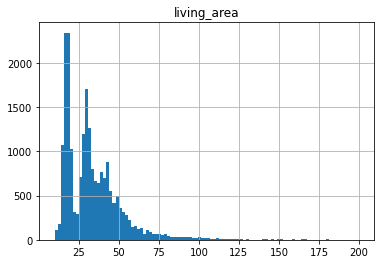

In [52]:
data.hist('living_area', bins=100);

Имеются два пика - на 18 кв.м. и на 30 кв.м. Нужно проверить, почему именно два пика и почему есть явный провал около 24 кв.м.

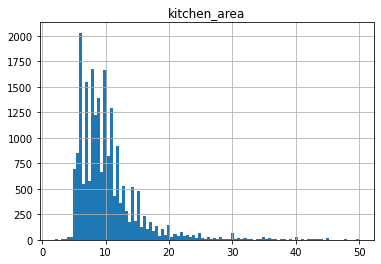

In [53]:
data.hist('kitchen_area', bins=100);

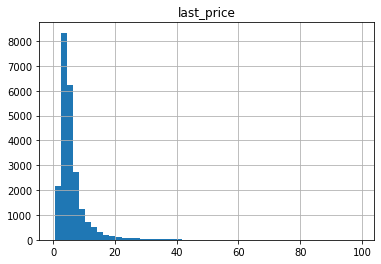

In [54]:
data['last_price'] = data['last_price'] / 1000000
data.hist('last_price', bins=50);

Немного "шумный" график. Очень длинный "хвост" вправо - это элитная недвижимость.

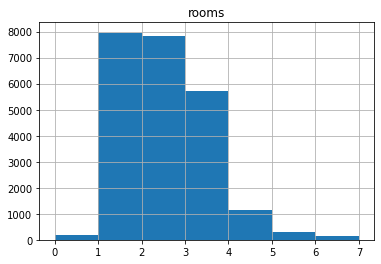

In [55]:
data.hist('rooms', bins=7);

Больше всего двух- и трёх-комнатных квартир. Затем идут четырехкомнатные квартиры.

array([[<AxesSubplot:title={'center':'ceiling_height'}>]], dtype=object)

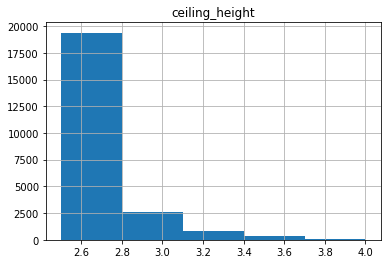

In [56]:
data.hist('ceiling_height', bins=5)

Здесь два пика 2.5м и 3м, это принятые стандарты, которые встречаются в большинстве случаев.

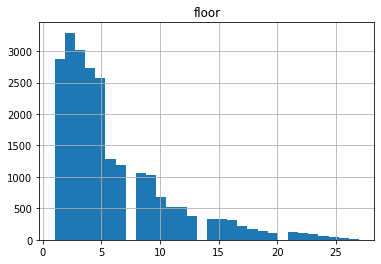

In [57]:
data.hist('floor', bins=30);

Больше всего квартир с 1 по 5 этаж. В Санкт-Петербурге и области мало высотных зданий.

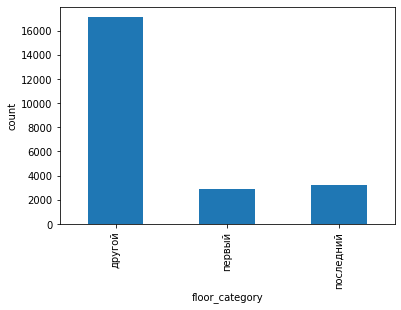

In [58]:
data.groupby(by='floor_category')['floor_category'].count().plot(kind='bar', ylabel = 'count');

Больше всего квартир на "другом" этаже. Это логично. Первых и последних этажей одинакого мало.

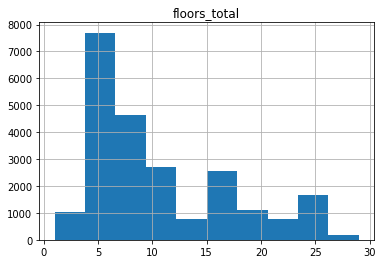

In [59]:
data.hist('floors_total', bins=10);

Видим пики: 5-этажная застройка, 9-этажная застройка, и наблюдаются пики более высоких новостроек.

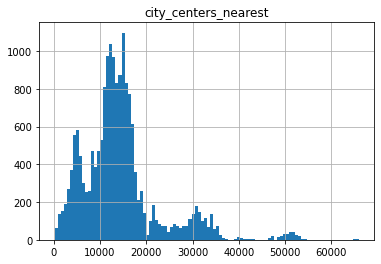

In [60]:
data.hist('city_centers_nearest', bins=100);

Наблюдаются два ярко выраженных пика: 5 км и от 10 км до 15 км. Так же есть совсем небольшие всплески на 30 км и 50 км.

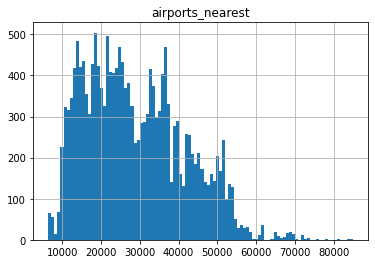

In [61]:
data.hist('airports_nearest', bins=100);

Здесь лицезреем достаточно "шумный" график. Это вполне ожидаемо.

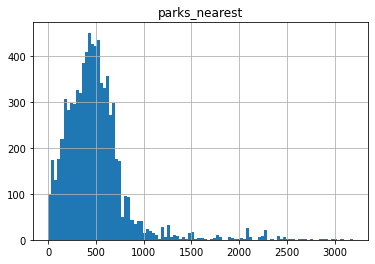

In [62]:
data.hist('parks_nearest', bins=100);

График показывает больше всего квартир с парками на расстоянии до 750м

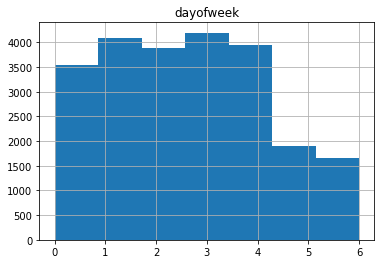

In [63]:
data.hist('dayofweek', bins=7);

Имеется спад в публикации объявлений в субботу и воскресенье, это закономерная тенденция.

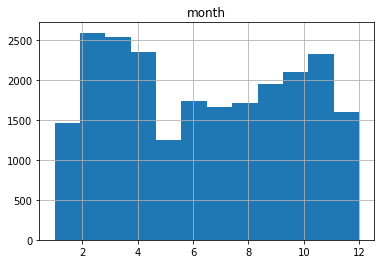

In [64]:
data.hist('month', bins=12);

С февраля по апрель имелась повышенная активность. Так же был плавный рост активности с июня по ноябрь. Провалы в декабре, январе и мае.

Среднее время продажи квартиры в днях: 171
Медианное время продажи квартиры в днях: 93

[Выбросы] Количество объявлений, которые сняты через:
45 дней: 870
60 дней: 535
90 дней: 202


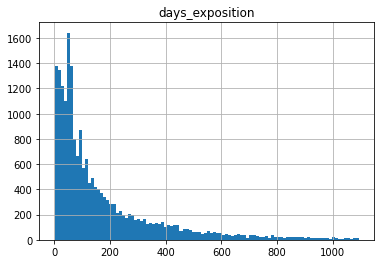

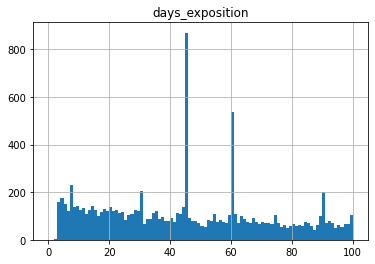

In [65]:
data.hist('days_exposition', bins=100);
data.hist('days_exposition', bins=100, range = (0,100));
print(f'Среднее время продажи квартиры в днях:',int(data['days_exposition'].mean()))
print('Медианное время продажи квартиры в днях:',int(data['days_exposition'].median()))

print('\n[Выбросы] Количество объявлений, которые сняты через:')
print('45 дней:',data[data['days_exposition']==45]['days_exposition'].count())
print('60 дней:',data[data['days_exposition']==60]['days_exposition'].count())
print('90 дней:',data[data['days_exposition']==90]['days_exposition'].count())

Среднее время продажи квартиры равняется 180 дням. Если обратиться к медиане, 95 дней, в два раза меньше, т.к. имеется "длинный хвост" квартир, которые продавались очень долго - годами.
Исходя из этого, можно утверждать, что быстрыми продажи являются сделки до 95 дней, а долгими - свыше 180 дней.

In [66]:
list_for_graph = ['total_area',
                  'living_area',
                  'kitchen_area',
                  'rooms',
                  'floor_category_digit']

for entry in list_for_graph:
    correlation = data['last_price'].corr(data[entry])
    print(f'Корреляция между last_price и {entry} составляет: {correlation:0.2%}')

Корреляция между last_price и total_area составляет: 75.51%
Корреляция между last_price и living_area составляет: 66.55%
Корреляция между last_price и kitchen_area составляет: 56.00%
Корреляция между last_price и rooms составляет: 45.80%
Корреляция между last_price и floor_category_digit составляет: 5.71%


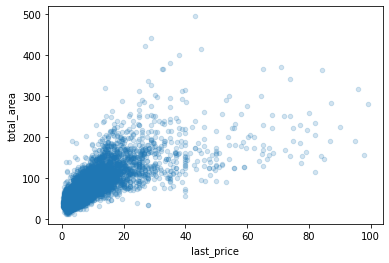

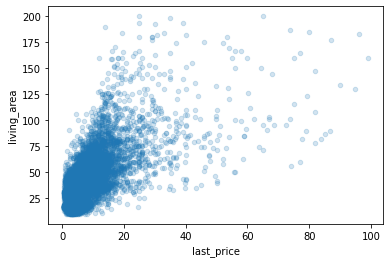

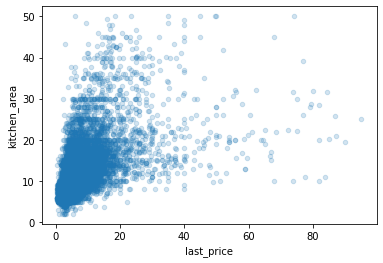

In [67]:
data.plot(x='last_price', y='total_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='living_area', kind='scatter', alpha=0.2)
data.plot(x='last_price', y='kitchen_area', kind='scatter', alpha=0.2);

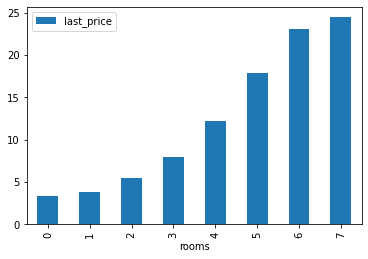

In [68]:
data.pivot_table(index='rooms',values='last_price').plot(y='last_price', kind='bar');

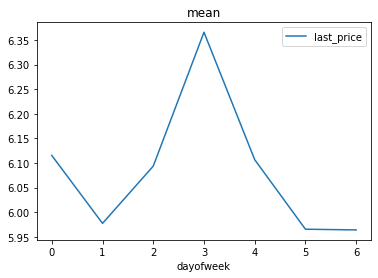

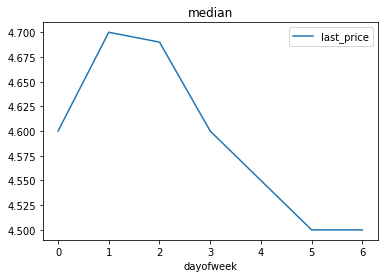

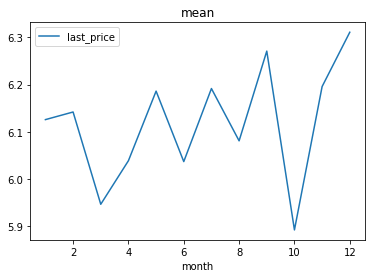

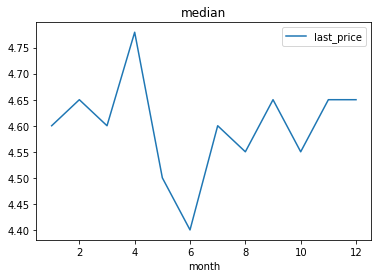

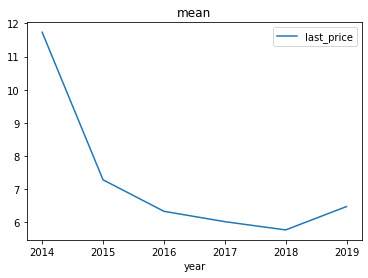

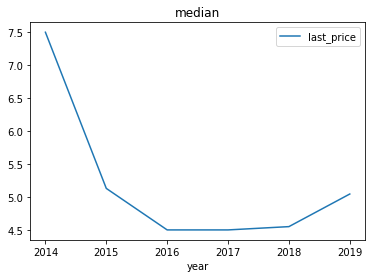

In [69]:
data.pivot_table(index='dayofweek',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
data.pivot_table(index='dayofweek',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median')

data.pivot_table(index='month',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
data.pivot_table(index='month',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median')

data.pivot_table(index='year',values='last_price',aggfunc='mean').plot(y='last_price', kind='line', title='mean')
data.pivot_table(index='year',values='last_price',aggfunc='median').plot(y='last_price', kind='line', title='median');

Цена зависит от: общей площади, жилой площади, площади кухни, количества комнат.
Цена практически на зависит от: этажа, даты размещения.

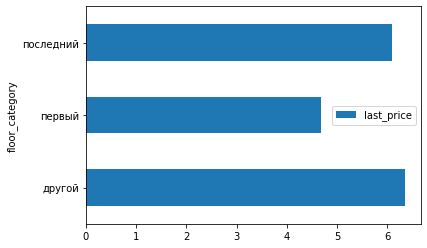

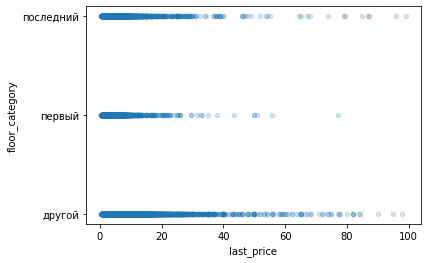

In [70]:
data.pivot_table(index='floor_category',values='last_price').plot(y='last_price', kind='barh')
data.plot(x='last_price', y='floor_category', kind='scatter', alpha=0.2);

<AxesSubplot:ylabel='locality_name'>

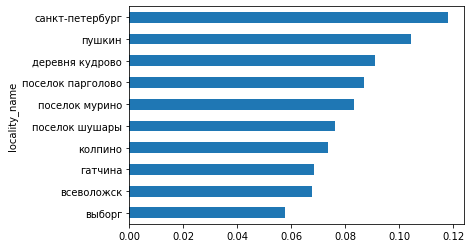

In [71]:
top_10 = data.pivot_table(index='locality_name', values=['last_price','total_area'] ,aggfunc=['sum','count'])
top_10.columns=['last_price_sum','total_area_sum','last_price_count','total_area_count']
top_10.pop('total_area_count')
top_10.sort_values(by=['last_price_count'],ascending=False, inplace=True)
top_10 = top_10.iloc[:10]
top_10['price_per_sq_m'] = top_10['last_price_sum']/top_10['total_area_sum']
top_10.sort_values(by=['price_per_sq_m'],ascending=True, inplace=True)
top_10['price_per_sq_m'].plot(kind='barh')

In [72]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_centers_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,cost_per_sqm,dayofweek,month,year,floor_category,floor_category_digit,city_centers_nearest_km
0,20,13.000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,санкт-петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,<NA>,120370.370370,3,3,2019,другой,1,16
1,7,3.350,40.4,2018-12-04,1,2.70,11,18.6,1,False,False,False,11.0,2,поселок шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81,82920.792079,1,12,2018,первый,0,19
2,10,5.196,56.0,2015-08-20,2,2.70,5,34.3,4,False,False,False,8.3,0,санкт-петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558,92785.714286,3,8,2015,другой,1,14
3,0,64.900,159.0,2015-07-24,3,2.70,14,NaN,9,False,False,False,NaN,0,санкт-петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424,408176.100629,4,7,2015,другой,1,7
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,санкт-петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121,100000.000000,1,6,2018,другой,1,8


In [73]:
data['rooms'].value_counts()

1    7957
2    7814
3    5702
4    1138
5     297
0     192
6      94
7      44
Name: rooms, dtype: int64

In [74]:
data.groupby(by='rooms')['rooms'].count().sort_values(ascending=False)

rooms
1    7957
2    7814
3    5702
4    1138
5     297
0     192
6      94
7      44
Name: rooms, dtype: int64

    Самые дорогие квартиры в Санкт-Петербурге. И в ближайших к нему населенных пунктах.

<AxesSubplot:xlabel='city_centers_nearest_km'>

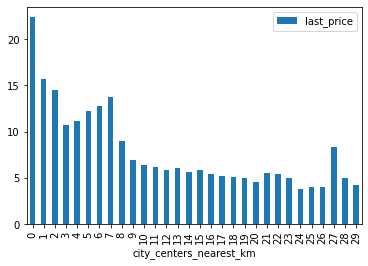

In [75]:
(
    data[data['locality_name']=='санкт-петербург']
    .pivot_table(
        index='city_centers_nearest_km',
        values='last_price',
        aggfunc='mean')
    .plot(kind='bar')
)

Самая дорогая недвижимость до 1км.
Более низкие цены на недвижимость на расстоянии от 1 км. до 7 км. включительно.
Далее цена спадает на расстоянии от 8 км. до 27 км.
Затем имеется пик на 27км, вероятно, это недвижимость в премиальном районе.

### Общий вывод

Было проведено исследование, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.
Входные данные - данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.
Результаты исследования могут быть использованы риелторами, статистами или при прогнозировании продаж.

Перед проведением исследования были поставлены несколько гипотез:
    Гипотеза 1: влияет на общую стоимость объекта общая площадь;
    Гипотеза 2: влияет на общую стоимость объекта жилая площадь;
    Гипотеза 3: влияет на общую стоимость объекта площадь кухни;
    Гипотеза 4: влияет на общую стоимость объекта количество комнат;
    Гипотеза 5: влияет на общую стоимость объекта этаж, на котором расположена квартира;
    Гипотеза 6: стоимость объекта зависит от расстояния до центра города.
        
В результате удалось выявить зависимости.

Гипотеза 1 подтверждена: общая площадь объекта влияет на стоимость объекта - 76%.
Гипотеза 2 подтверждена: жилая площадь объекта влияет на стоимость объекта на - 67%.
Гипотеза 3 подтверждена: площадь кухни объекта влияет на стоимость объекта на - 56%.
Гипотеза 4 подтверждена частично: корреляция между количеством комнат и стоимостью объектов - 46%.
Гипотеза 5 не подтверждена: этаж объекта не влияет на итоговую стоимость - 6%.
Гипотеза 6 подтверждена: самые догогие объекты в радиусе 1 км от центра города.
    
Общие вывод:
1. Итоговая цена продаваемого объекта в большей мере зависит от его общей площади.
2. На конечную стоимость оказывают такие параметры как жилая площадь, площадь кухни и в некоторых случаях количество комнат.
3. Влияние на итоговую цену оказывает расположение объекта, чем ближе к центру, тем дороже.
4. Этаж, на котором расположен продаваемый объект, не оказывает влияния.